title: New standard launch and growth in spring 2021
author: Fabio Schmidt-Fischbach, Wendy Vu     
date: 2021-05-01     
region: EU   
link: https://docs.google.com/presentation/d/1tFWKeT-MGceCYbye6SlpL7cSZ8k5SURqANSbZEn74-U/edit?usp=sharing  
tags: memberships, growth, premium signups, kyc, marketing, retention, mau, new standard, launch, product   
summary: This looks at the growth impact of new standard launch in early 2021.

In [1]:
#!pip install pycausalimpact

import pandas as pd
import numpy as np
import altair as alt

!pip install pycausalimpact
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact

In [ ]:
query = """
select date_trunc('week',date) as week,
		country,
		'spend' as label, sum(cost_with_vat::float) 
from dbt.zrh_mktg_spend 
where week < date_trunc('week', current_date) and week >= '2019-01-01'
group by 1,2

union all 

select date_trunc('week', kyc_first_completed::date) as week,
		country_tnc_legal as country, 
		'KYCc' as label , count(1)
from dbt.zrh_users
where week < date_trunc('week', current_date) and week >= '2019-01-01'
group by 1,2 

union all 

select date_trunc('week', ft_mau::date) as week,
		country_tnc_legal as country, 
		'ftMAU' as label , count(1)
from dbt.zrh_users
where week < date_trunc('week', current_date) and week >= '2019-01-01'
group by 1,2 
"""

In [70]:
df = pd.read_csv("baseline.csv")

df = pd.pivot_table(
    df, values=["sum"], index=["week"], columns=["label"], aggfunc=np.sum
).reset_index()
df.columns = ["week", "KYCc", "ftMAU", "spend"]

df["Spend"] = df["spend"].rolling(4).mean()
df["KYCc"] = df["KYCc"].rolling(4).mean()

df = df.loc[:, ["week", "KYCc", "Spend"]]

base = alt.Chart(df.loc[df["week"] >= "2020-01-01", :]).encode(
    x="yearmonthdate(week):O"
)

line1 = base.mark_line(stroke="#5276A7").encode(
    alt.Y("KYCc:Q", axis=alt.Axis(title="KYC completion", titleColor="#5276A7")),
)

line2 = base.mark_line(stroke="#57A44C").encode(
    alt.Y("Spend:Q", axis=alt.Axis(title="Marketing spend", titleColor="#57A44C")),
)


alt.layer(line1, line2).resolve_scale(y="independent").properties(width=500, height=400)

alt.LayerChart(...)

In [38]:
df = pd.read_csv("baseline.csv")

df = pd.pivot_table(
    df, values=["sum"], index=["week"], columns=["label"], aggfunc=np.sum
).reset_index()
df.columns = ["week", "KYCc", "ftMAU", "spend"]

df["4-week rolling average"] = df["KYCc"].rolling(4).mean()
df = df.loc[:, ["week", "KYCc", "4-week rolling average"]]

df = pd.melt(df, id_vars=["week"])

alt.Chart(df.loc[df["week"] >= "2020-01-01", :]).mark_line().encode(
    x="yearmonthdate(week):O", y="value:Q", color="variable:N"
).properties(width=500, height=400, title="KYC completed")

alt.Chart(...)

In [146]:
df = pd.read_csv("baseline.csv")

df = pd.pivot_table(
    df, values=["sum"], index=["week"], columns=["label"], aggfunc=np.sum
).reset_index()
df.columns = ["week", "KYCc", "ftMAU", "spend"]

df.index = pd.to_datetime(df["week"])

df["CAC2"] = df["spend"] / df["KYCc"]
df["4-week rolling average"] = (
    df["spend"].rolling(4).mean() / df["KYCc"].rolling(4).mean()
)

df = df.loc[:, ["week", "CAC2", "4-week rolling average"]]

df = pd.melt(df, id_vars=["week"])

alt.Chart(df.loc[df["week"] >= "2020-06-01", :]).mark_line().encode(
    x="yearmonthdate(week):O",
    y=alt.Y("value:Q", axis=alt.Axis(title="CAC2")),
    color="variable:N",
).properties(width=500, height=400, title="CAC-2")

alt.Chart(...)

## report on gre

In [92]:
df = pd.read_csv("baseline.csv")

df.loc[
    df["country"].isin(["FRA", "DEU", "AUT", "ESP", "ITA"]) == False, "country"
] = "RoE"

df = pd.pivot_table(
    df, values=["sum"], index=["week", "country"], columns=["label"], aggfunc=np.sum
).reset_index()
df.columns = ["week", "country", "KYCc", "ftMAU", "spend"]


new_column = df.groupby(["country"])["KYCc"].rolling(4).mean()
df["KYC rolling"] = new_column.reset_index(level=0, drop=True)

alt.Chart(df.loc[df["week"] >= "2020-08-01", :]).mark_line().encode(
    x="yearmonthdate(week):O",
    y=alt.Y("KYC rolling:Q", axis=alt.Axis(title="KYC - rolling average (4wk)")),
).properties(width=300, height=200, title="KYC - rolling average (4wk)").facet(
    columns=3, facet="country:N"
).resolve_scale(
    y="independent"
)

alt.FacetChart(...)

/Users/fabioschmidt-fischbach/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/Users/fabioschmidt-fischbach/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


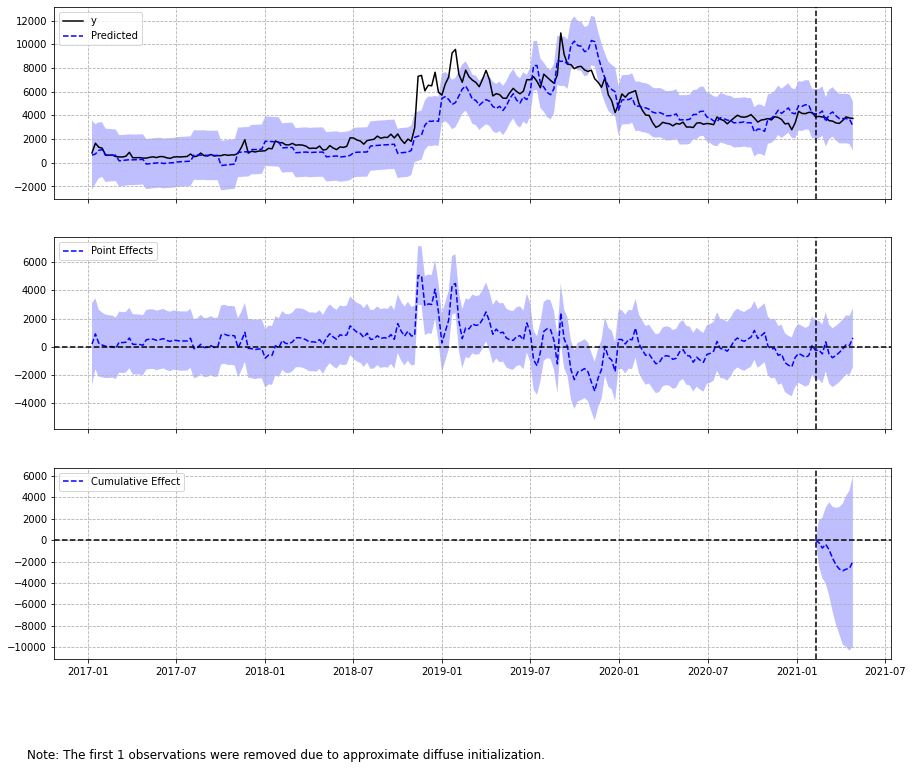

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    3666.09            40327.0
Prediction (s.d.)         3846.72 (368.51)   42313.94 (4053.64)
95% CI                    [3123.32, 4567.87] [34356.57, 50246.55]

Absolute effect (s.d.)    -180.63 (368.51)   -1986.94 (4053.64)
95% CI                    [-901.78, 542.77]  [-9919.55, 5970.43]

Relative effect (s.d.)    -4.7% (9.58%)      -4.7% (9.58%)
95% CI                    [-23.44%, 14.11%]  [-23.44%, 14.11%]

Posterior tail-area probability p: 0.3
Posterior prob. of a causal effect: 69.83%

For more details run the command: print(impact.summary('report'))


In [38]:
df = pd.read_csv("baseline_allyears.csv")

df = df.loc[df["country"].isin(["FRA", "DEU", "AUT", "ESP", "ITA"]) == False, :]
df = pd.pivot_table(
    df, values=["sum"], index=["week"], columns=["label"], aggfunc=np.sum
).reset_index()
df.columns = ["week", "KYCc", "ftMAU", "spend"]

df.index = pd.to_datetime(df["week"])
df = df.loc[df.index >= pd.to_datetime("2017-01-01"), :]

post_period = [pd.to_datetime("2021-02-15"), pd.to_datetime("2021-04-26")]
pre_period = [pd.to_datetime("2017-01-02"), pd.to_datetime("2021-02-08")]

dummies = pd.get_dummies(pd.to_datetime(df["week"]).dt.month)
dummies.columns = [
    "january",
    "february",
    "march",
    "april",
    "mai",
    "june",
    "july",
    "august",
    "september",
    "october",
    "november",
    "december",
]
df = pd.concat([df, dummies], axis=1)

ci = CausalImpact(df.drop(columns=["week", "ftMAU"]), pre_period, post_period)

ci.plot()
print(ci.summary())

In [17]:
ci.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                   KYCc   No. Observations:                  110
Model:                    local level   Log Likelihood                 -90.402
Date:                Thu, 06 May 2021   AIC                            210.804
Time:                        10:06:42   BIC                            251.175
Sample:                    01-07-2019   HQIC                           227.176
                         - 02-08-2021                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.2314      0.044      5.202      0.000       0.144       0.319
sigma2.level         0.0001   8.78e-05      1.639      0.101   -2.82e-05       0.000
beta.spend           0.6877      0.092      7.496      0.000       0.508       0.868
beta.january         0.2266      0.040      5.722      0.000       0.149       0.304
beta.february        0.1034      0.050      2.082      0.037       0.006       0.201
beta.march          -0.0077      0.045     -0.170      0.865      -0.096       0.081
beta.april           0.0189      0.044      0.428      0.669      -0.068       0.106
beta.mai            -0.0685      0.055     -1.256      0.209      -0.175       0.038
beta.june           -0.0941      0.044     -2.141      0.032      -0.180      -0.008
beta.july           -0.0604      0.043     -1.388      0.165      -0.146       0.025
beta.august          0.0338      0.050      0.670      0.503      -0.065       0.133
beta.september       0.0826      0.045      1.841      0.066      -0.005       0.171
beta.october        -0.0949      0.059     -1.618      0.106      -0.210       0.020
beta.november       -0.1042      0.055     -1.892      0.058      -0.212       0.004
beta.december       -0.0806      0.050     -1.598      0.110      -0.179       0.018
===================================================================================
Ljung-Box (Q):                      133.58   Jarque-Bera (JB):                14.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.74
Prob(H) (two-sided):                  0.53   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.62e+17. Standard errors may be unstable.
"""

In [143]:
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_csv("baseline_allyears.csv")

df = pd.pivot_table(
    df, values=["sum"], index=["week"], columns=["label"], aggfunc=np.sum
).reset_index()
df.columns = ["week", "KYCc", "ftMAU", "spend"]

df.index = pd.to_datetime(df["week"])
# 2016 to now.
df = df.loc[df.index >= pd.to_datetime("2016-01-01"), :]

sc = pd.DataFrame(
    seasonal_decompose(df["KYCc"], model="additive").seasonal
).reset_index()

sc["week"] = pd.to_datetime(sc["week"])
sc["year"] = sc["week"].dt.year
sc["wk"] = sc["week"].dt.week

alt.Chart(pd.DataFrame(sc)).mark_line().encode(
    x=alt.X("wk", axis=alt.Axis(title="Calendar week")),
    y=alt.Y("seasonal:Q", axis=alt.Axis(title="Seasonal component of KYC (all time)")),
).properties(title="Seasonal decomposition of KYC figures (2016-2021)")

/Users/fabioschmidt-fischbach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  app.launch_new_instance()


alt.Chart(...)

## italy and spain

/Users/fabioschmidt-fischbach/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/Users/fabioschmidt-fischbach/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


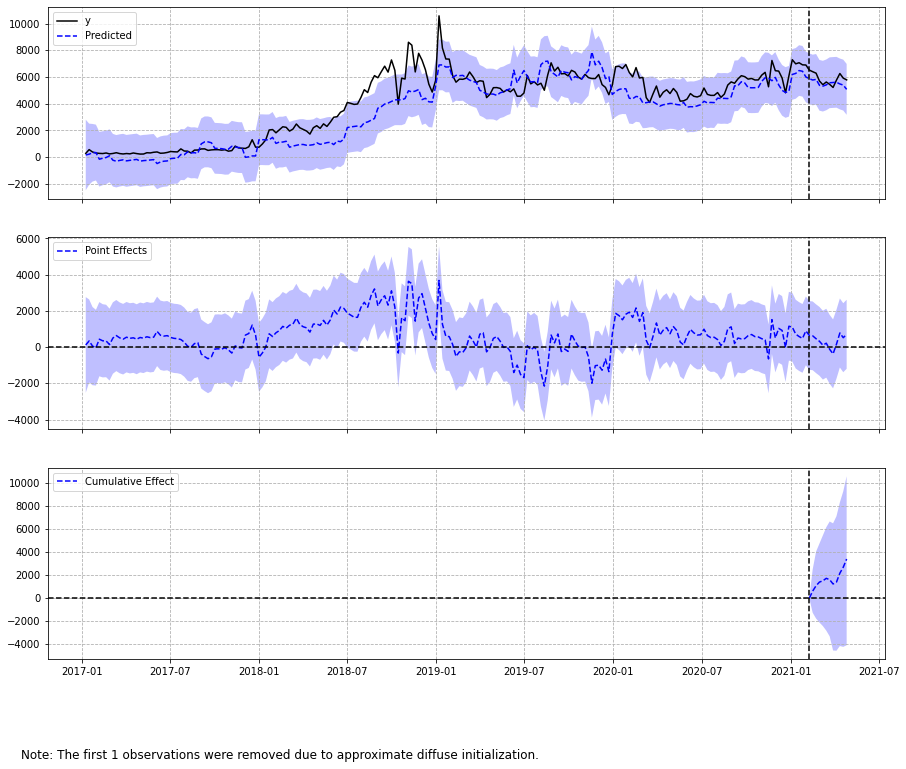

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    5803.73            63841.0
Prediction (s.d.)         5493.52 (341.36)   60428.68 (3754.95)
95% CI                    [4838.41, 6176.51] [53222.53, 67941.64]

Absolute effect (s.d.)    310.21 (341.36)    3412.32 (3754.95)
95% CI                    [-372.79, 965.32]  [-4100.64, 10618.47]

Relative effect (s.d.)    5.65% (6.21%)      5.65% (6.21%)
95% CI                    [-6.79%, 17.57%]   [-6.79%, 17.57%]

Posterior tail-area probability p: 0.19
Posterior prob. of a causal effect: 80.82%

For more details run the command: print(impact.summary('report'))


In [39]:
df = pd.read_csv("baseline_allyears.csv")

df = df.loc[df["country"].isin(["ESP", "ITA"]) == True, :]
df = pd.pivot_table(
    df, values=["sum"], index=["week"], columns=["label"], aggfunc=np.sum
).reset_index()
df.columns = ["week", "KYCc", "ftMAU", "spend"]

df.index = pd.to_datetime(df["week"])
df = df.loc[df.index >= pd.to_datetime("2017-01-02"), :]

post_period = [pd.to_datetime("2021-02-15"), pd.to_datetime("2021-04-26")]
pre_period = [pd.to_datetime("2017-01-02"), pd.to_datetime("2021-02-08")]

dummies = pd.get_dummies(pd.to_datetime(df["week"]).dt.month)
dummies.columns = [
    "january",
    "february",
    "march",
    "april",
    "mai",
    "june",
    "july",
    "august",
    "september",
    "october",
    "november",
    "december",
]
df = pd.concat([df, dummies], axis=1)

ci = CausalImpact(df.drop(columns=["week", "ftMAU"]), pre_period, post_period)

ci.plot()
print(ci.summary())

## fra


/Users/fabioschmidt-fischbach/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/Users/fabioschmidt-fischbach/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


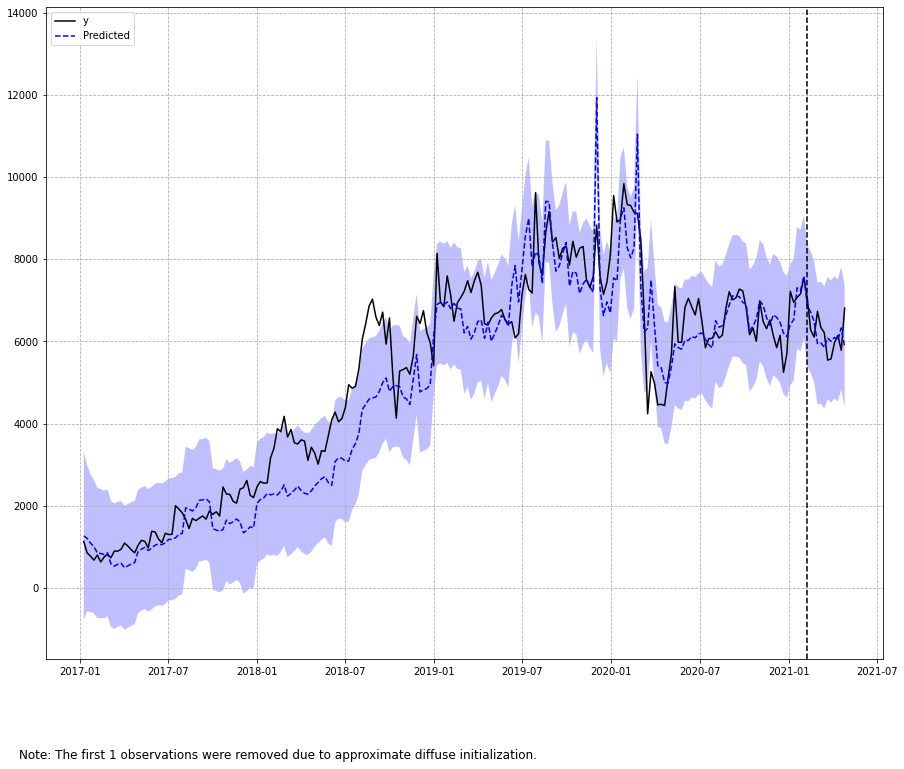

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    6137.73            67515.0
Prediction (s.d.)         6124.84 (274.21)   67373.22 (3016.32)
95% CI                    [5565.63, 6640.52] [61221.9, 73045.67]

Absolute effect (s.d.)    12.89 (274.21)     141.78 (3016.32)
95% CI                    [-502.79, 572.1]   [-5530.67, 6293.1]

Relative effect (s.d.)    0.21% (4.48%)      0.21% (4.48%)
95% CI                    [-8.21%, 9.34%]    [-8.21%, 9.34%]

Posterior tail-area probability p: 0.48
Posterior prob. of a causal effect: 51.65%

For more details run the command: print(impact.summary('report'))


In [42]:
df = pd.read_csv("baseline_allyears.csv")

df = df.loc[df["country"].isin(["FRA"]) == True, :]
df = pd.pivot_table(
    df, values=["sum"], index=["week"], columns=["label"], aggfunc=np.sum
).reset_index()
df.columns = ["week", "KYCc", "ftMAU", "spend"]

df.index = pd.to_datetime(df["week"])
df = df.loc[df.index >= pd.to_datetime("2017-01-01"), :]

post_period = [pd.to_datetime("2021-02-15"), pd.to_datetime("2021-04-26")]
pre_period = [pd.to_datetime("2017-01-02"), pd.to_datetime("2021-02-08")]


dummies = pd.get_dummies(pd.to_datetime(df["week"]).dt.month)
dummies.columns = [
    "january",
    "february",
    "march",
    "april",
    "mai",
    "june",
    "july",
    "august",
    "september",
    "october",
    "november",
    "december",
]
df = pd.concat([df, dummies], axis=1)

ci = CausalImpact(df.drop(columns=["week", "ftMAU"]), pre_period, post_period)

ci.plot(panels=["original"])
print(ci.summary())

## DEU 

/Users/fabioschmidt-fischbach/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/Users/fabioschmidt-fischbach/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


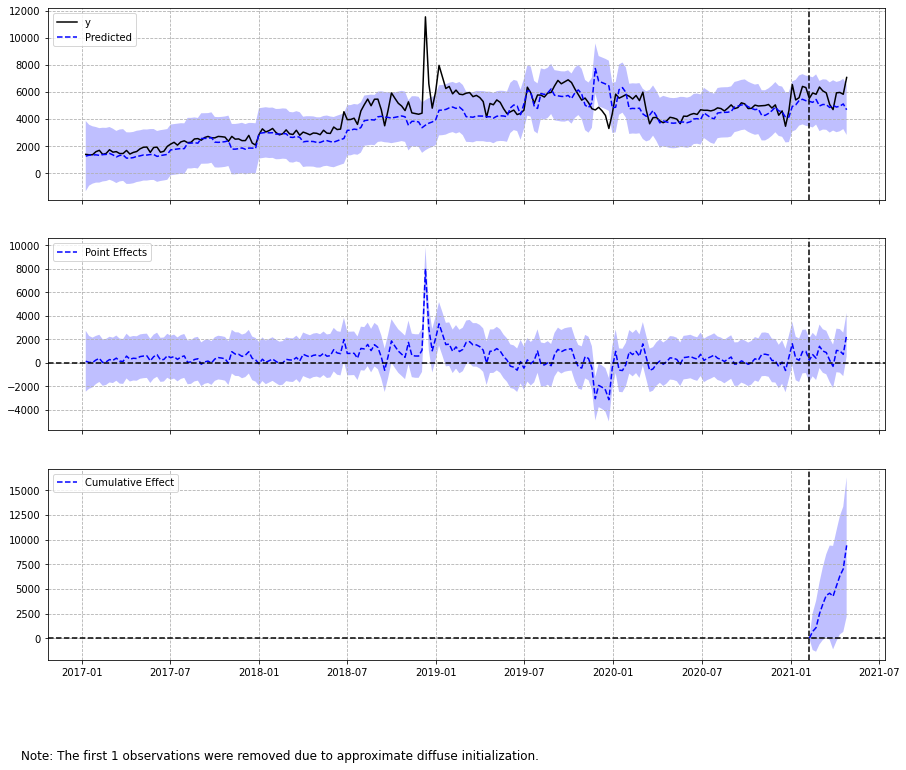

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    5879.36            64673.0
Prediction (s.d.)         5023.29 (327.87)   55256.18 (3606.61)
95% CI                    [4396.22, 5681.46] [48358.42, 62496.07]

Absolute effect (s.d.)    856.07 (327.87)    9416.82 (3606.61)
95% CI                    [197.9, 1483.14]   [2176.93, 16314.58]

Relative effect (s.d.)    17.04% (6.53%)     17.04% (6.53%)
95% CI                    [3.94%, 29.53%]    [3.94%, 29.53%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.5%

For more details run the command: print(impact.summary('report'))


In [41]:
df = pd.read_csv("baseline_allyears.csv")

df = df.loc[df["country"].isin(["DEU", "AUT"]) == True, :]
df = pd.pivot_table(
    df, values=["sum"], index=["week"], columns=["label"], aggfunc=np.sum
).reset_index()
df.columns = ["week", "KYCc", "ftMAU", "spend"]

df.index = pd.to_datetime(df["week"])
df = df.loc[df.index >= pd.to_datetime("2017-01-01"), :]

post_period = [pd.to_datetime("2021-02-15"), pd.to_datetime("2021-04-26")]
pre_period = [pd.to_datetime("2017-01-02"), pd.to_datetime("2021-02-08")]

dummies = pd.get_dummies(pd.to_datetime(df["week"]).dt.month)
dummies.columns = [
    "january",
    "february",
    "march",
    "april",
    "mai",
    "june",
    "july",
    "august",
    "september",
    "october",
    "november",
    "december",
]
df = pd.concat([df, dummies], axis=1)

ci = CausalImpact(df.drop(columns=["week", "ftMAU"]), pre_period, post_period)

ci.plot()
print(ci.summary())